# Attention Monitoring V2

I performed image and video classification with a Convolutional Neural Network in Python using TensorFlow Keras.

In [1]:
# Construct the path
DATA_PATH = "data"
TRAIN_PATH = '%s/train/' % (DATA_PATH)
VALID_PATH = '%s/valid/' % (DATA_PATH)
TEST_PATH = '%s/test/' % (DATA_PATH)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width = 224
image_height = 224
image_size = (image_width, image_height)

# 32 images will be processed at a time
batch_size = 32 

# initialize training generator
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')

# initialize validation generator
validation_datagen = ImageDataGenerator(rescale=1.0/255) # we only need to scale the input for validation set
validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')

# initialize testing generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
        TEST_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')


Found 7302 images belonging to 2 classes.
Found 1561 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.


In [3]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential, Model

conv_base = ResNet152V2(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [4]:
res_model = conv_base.output
res_model = MaxPooling2D((3, 3))(res_model)
res_model = Flatten()(res_model)
res_model = Dense(512, activation="relu")(res_model)
res_model = Dropout(0.5)(res_model)
res_model = Dense(1, activation='sigmoid')(res_model)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=conv_base.input, outputs=res_model)


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 62,526,977
Trainable params: 62,383,233
Non-trainable params: 143,744
__________________________________________________________________________________________________


In [6]:
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
True

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
True

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
True

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
True

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
True

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
True

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
True

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
True

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
True

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
True

11: <tensorflow.python.

In [7]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in conv_base.layers:
    layer.trainable = False

In [8]:
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
False

11: <tensorfl

In [ ]:
# # reset our data generators
# train_generator.reset()
# validation_generator.reset()
# test_generator.reset()

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
%load_ext tensorboard
%tensorboard --logdir './resnet152v2/logs'
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model = ModelCheckpoint("./resnet152v2/attentions_resnet152v2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_loss', patience = 50, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(
            train_generator,
            steps_per_epoch=None, #366, #7302/20, 20 is the batch size
            validation_steps=None, #79, #1561/20
            epochs=200, # Change this to a bigger number if you want to train for more epochs
            validation_data=validation_generator,
            callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs')])

Reusing TensorBoard on port 6006 (pid 29404), started 1 day, 0:28:00 ago. (Use '!kill 29404' to kill it.)

C:\Users\Tyrone\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/200
229/229 [==============================] - 1546s 7s/step - loss: 1.0019 - accuracy: 0.6845 - val_loss: 0.5148 - val_accuracy: 0.7136

Epoch 00001: val_accuracy improved from -inf to 0.71365, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 2/200
229/229 [==============================] - 1492s 7s/step - loss: 0.5112 - accuracy: 0.7399 - val_loss: 0.5157 - val_accuracy: 0.7034

Epoch 00002: val_accuracy did not improve from 0.71365
Epoch 3/200
229/229 [==============================] - 1492s 7s/step - loss: 0.4907 - accuracy: 0.7462 - val_loss: 0.4750 - val_accuracy: 0.7406

Epoch 00003: val_accuracy improved from 0.71365 to 0.74055, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 4/200
229/229 [==============================] - 1486s 6s/step - loss: 0.4891 - accuracy: 0.7495 - val_loss: 0.5154 - val_accuracy: 0.7021

Epoch 00004: val_accuracy did not improve from 0.74055
Epoch 5/200
229/229 [==============================] - 1489s 7s/step - loss: 

229/229 [==============================] - 1786s 8s/step - loss: 0.4272 - accuracy: 0.7825 - val_loss: 0.4343 - val_accuracy: 0.7521

Epoch 00040: val_accuracy did not improve from 0.76233
Epoch 41/200
229/229 [==============================] - 1702s 7s/step - loss: 0.4218 - accuracy: 0.7917 - val_loss: 0.4335 - val_accuracy: 0.7489

Epoch 00041: val_accuracy did not improve from 0.76233
Epoch 42/200
229/229 [==============================] - 1670s 7s/step - loss: 0.4080 - accuracy: 0.7990 - val_loss: 0.4400 - val_accuracy: 0.7521

Epoch 00042: val_accuracy did not improve from 0.76233
Epoch 43/200
229/229 [==============================] - 1537s 7s/step - loss: 0.4164 - accuracy: 0.7928 - val_loss: 0.4449 - val_accuracy: 0.7636

Epoch 00043: val_accuracy improved from 0.76233 to 0.76361, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 44/200
229/229 [==============================] - 2918s 13s/step - loss: 0.4134 - accuracy: 0.7866 - val_loss: 0.4580 - val_accuracy: 0.75


Epoch 00079: val_accuracy did not improve from 0.77194
Epoch 80/200
229/229 [==============================] - 1481s 6s/step - loss: 0.3972 - accuracy: 0.7973 - val_loss: 0.4268 - val_accuracy: 0.7585

Epoch 00080: val_accuracy did not improve from 0.77194
Epoch 81/200
229/229 [==============================] - 1482s 6s/step - loss: 0.4031 - accuracy: 0.7929 - val_loss: 0.4227 - val_accuracy: 0.7630

Epoch 00081: val_accuracy did not improve from 0.77194
Epoch 82/200
229/229 [==============================] - 1483s 6s/step - loss: 0.4074 - accuracy: 0.7954 - val_loss: 0.4231 - val_accuracy: 0.7751

Epoch 00082: val_accuracy improved from 0.77194 to 0.77514, saving model to ./resnet152v2\attentions_resnet152v2.h5
Epoch 83/200
229/229 [==============================] - 1487s 6s/step - loss: 0.4007 - accuracy: 0.7966 - val_loss: 0.4168 - val_accuracy: 0.7546

Epoch 00083: val_accuracy did not improve from 0.77514
Epoch 84/200
229/229 [==============================] - 1514s 7s/step - los


Epoch 00119: val_accuracy did not improve from 0.77707
Epoch 120/200
229/229 [==============================] - 1289s 6s/step - loss: 0.3902 - accuracy: 0.8084 - val_loss: 0.4312 - val_accuracy: 0.7681

Epoch 00120: val_accuracy did not improve from 0.77707
Epoch 121/200
229/229 [==============================] - 1290s 6s/step - loss: 0.3902 - accuracy: 0.8017 - val_loss: 0.4193 - val_accuracy: 0.7675

Epoch 00121: val_accuracy did not improve from 0.77707
Epoch 122/200
229/229 [==============================] - 1297s 6s/step - loss: 0.3971 - accuracy: 0.7977 - val_loss: 0.4170 - val_accuracy: 0.7668

Epoch 00122: val_accuracy did not improve from 0.77707
Epoch 123/200
229/229 [==============================] - 1302s 6s/step - loss: 0.3931 - accuracy: 0.8047 - val_loss: 0.4419 - val_accuracy: 0.7700

Epoch 00123: val_accuracy did not improve from 0.77707
Epoch 124/200
229/229 [==============================] - 1287s 6s/step - loss: 0.3957 - accuracy: 0.7969 - val_loss: 0.4268 - val_ac

229/229 [==============================] - 1247s 5s/step - loss: 0.3830 - accuracy: 0.8042 - val_loss: 0.4382 - val_accuracy: 0.7662

Epoch 00160: val_accuracy did not improve from 0.77707
Epoch 161/200
229/229 [==============================] - 1320s 6s/step - loss: 0.3874 - accuracy: 0.8028 - val_loss: 0.4429 - val_accuracy: 0.7591

Epoch 00161: val_accuracy did not improve from 0.77707
Epoch 162/200
229/229 [==============================] - 1330s 6s/step - loss: 0.3935 - accuracy: 0.7994 - val_loss: 0.4100 - val_accuracy: 0.7668

Epoch 00162: val_accuracy did not improve from 0.77707
Epoch 163/200
229/229 [==============================] - 1412s 6s/step - loss: 0.3861 - accuracy: 0.8055 - val_loss: 0.4165 - val_accuracy: 0.7649

Epoch 00163: val_accuracy did not improve from 0.77707
Epoch 164/200
229/229 [==============================] - 1458s 6s/step - loss: 0.3865 - accuracy: 0.8021 - val_loss: 0.4234 - val_accuracy: 0.7566

Epoch 00164: val_accuracy did not improve from 0.77707

229/229 [==============================] - 1300s 6s/step - loss: 0.3681 - accuracy: 0.8135 - val_loss: 0.4349 - val_accuracy: 0.7694

Epoch 00200: val_accuracy did not improve from 0.77707


Doesn't seem like the model restored the best weights...

In [ ]:
# I save the final model to disk
model.save("./resnet152v2/model", save_format="h5")

In [ ]:
# #####################################################
# from keras.models import load_model
# model_test = load_model('./resnet152v2/attentions_resnet152v2.h5')
                    
# history_test = model_test.fit(
#             train_generator,
#             steps_per_epoch=None, #366, #7302/20, 20 is the batch size
#             validation_steps=None, #79, #1561/20
#             epochs=100, # Change this to a bigger number if you want to train for more epochs
#             validation_data=validation_generator,
#             callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs')])

In [10]:

# serialize the model to disk
model.save("./resnet152v2/model", save_format="h5")




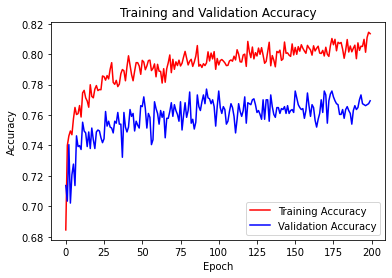

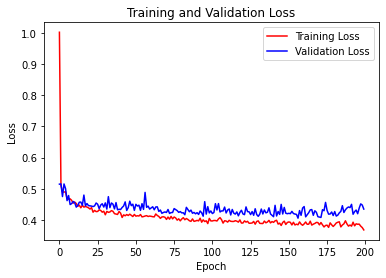

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/Accuracy1.jpg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/Loss1.jpg')

plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 250s 5s/step - loss: 0.4207 - accuracy: 0.7545


In [13]:
from tensorflow.keras.models import load_model
model2 = load_model('./resnet152v2/attentions_resnet152v2.h5')

In [14]:
test_generator.reset()
test_loss, test_acc = model2.evaluate(test_generator, steps=None, verbose=1)

49/49 [==============================] - 247s 5s/step - loss: 0.4209 - accuracy: 0.7615


In [15]:
# Shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
False

11: <tensorfl

In [16]:
# Unfreeze the last convulutional block in ResNet152
for layer in conv_base.layers[528:]:
    layer.trainable = True

In [17]:
# Again, shows which layers in the base model are trainable
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

1: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001BDBFE48EB0>: 
False

2: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFEF0370>: 
False

3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFEF0A90>: 
False

4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001BDFFFAAE50>: 
False

5: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001BDFFF44310>: 
False

6: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFFBD310>: 
False

7: <tensorflow.python.keras.layers.core.Activation object at 0x000001BDFFFB43A0>: 
False

8: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001BDFFFE51C0>: 
False

9: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001BDFFEF0760>: 
False

10: <tensorflow.python.keras.layers.core.Activation object at 0x000001BD890E22E0>: 
False

11: <tensorfl

In [18]:
# Reset the data generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [19]:
# I use the same optimizer with a smaller learning reate
from tensorflow.keras.optimizers import Adam
opt=Adam(learning_rate=1e-4)

In [ ]:
# Retrain the top layers of the model
%reload tensorboard --logdir './resnet152v2/logs_2'
%tensorboard --logdir './resnet152v2/logs_2'
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
best_model = ModelCheckpoint("./resnet152v2/attentions_resnet152v2_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_loss', patience = 50, verbose=1, mode='min', restore_best_weights=True)

history_2 = model2.fit(
            train_generator,
            steps_per_epoch=None, 
            validation_steps=None, 
            epochs=200, 
            callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs_2')])

In [ ]:
# Plot the loss and accuracy of the model over the training and validation data 
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/Accuracy_2.jpg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/Loss_2.jpg')

plt.show()

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator, steps=None, verbose=1)

In [ ]:
model3 = load_model('./resnet152v2/attentions_resnet152v2_2.h5')

test_generator.reset()
test_loss, test_acc = model2.evaluate(test_generator, steps=None, verbose=1)

In [ ]:
import cv2 as cv

VIDEO_NAME = "Example1"
VIDEO_IN = "videos/in/"
VIDEO_OUT = "videos/out/"

frame_width, frame_height = None, None

# size = 1
# Q = [deque(maxlen=args[size])] ########################
Q = []

classes = ['ATTENTIVE', 'NOT ATTENTIVE']

cap = cv.VideoCapture(VIDEO_IN+VIDEO_NAME)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
    
writer = None

# Loop over frames from the video stream
while True:
    # Capture frame-by-frame
    is_present, frame = cap.read()

    # If is_present is false, frame was read incorrectly or we have 
    # reached the end of the video
    if not is_present:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Get frame dimensions if empty
    if frame_width is None or frame_height is None:
        frame_width, frame_height = frame.shape[:2]
        
    # Operations on the frame: Convert, Resize, Rescale
    output = frame.copy()
    frame = cv.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv.resize(frame, (224, 224)).astype("float32")
    frame *= 1.0/255
    
    # Classify the current frame
    preds = model2.predict(np.expand_dims(frame, axis=0))[0]
    preds = 0 if preds < .53 else 1
#     Q.append(preds)
    # perform prediction averaging over the current history of
    # previous predictions
#     results = np.array(Q).mean(axis=0)
#     i = np.argmax(results)
    label = classes[preds]    

    # draw the activity on the output frame
    text = f"{label}"
    cv.putText(output, text, (35, 50), cv.FONT_HERSHEY_SIMPLEX,
        1.25, (0, 255, 0), 5)
    
    # check if the video writer is None
    if writer is None:
        # Define the codec and create VideoWriter object
        fourcc = cv.VideoWriter_fourcc(*"DIVX")
        writer = cv.VideoWriter(VIDEO_OUT+VIDEO_NAME, fourcc, 30,
            (frame_width, frame_height), True)
        
    # write the output frame to disk
    writer.write(output)
    
    # show the output image
    cv.imshow("Output", output)
    
    key = cv.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
        
# release the file pointers
print("[INFO] cleaning up...")
cap.release()
writer.release()

In [ ]:

# plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig(plotPath)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=None, verbose=1)

In [ ]:
# initialize testing generator
# SHOULD HAVE DONE SO ABOVE
# DELETE AND KEEP THE ONE ABOVE AFTER TESTING!!!
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
        TEST_PATH,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

test_generator.reset()

history = model.predict(
            test_generator,
            steps=None)

history_np = np.argmax(history, axis=1)



In [ ]:
test_generator.class_indices.keys()

In [ ]:
test_generator.classes

In [ ]:
history[:10]

In [ ]:
r = [round(i) for i in history.flatten()]
r

In [ ]:
print(classification_report(test_generator.classes, r,
                           target_names=test_generator.class_indices.keys()))


In [ ]:
print(classification_report(test_generator.classes, history_np,
                           target_names=test_generator.class_indices.keys()))

In [ ]:
for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
# loop over the layers in the model and show which ones are trainable
# or not
for i, layer in enumerate(conv_base.layers, 1):
    print(f"{i}: {layer}: \n{layer.trainable}\n")

In [ ]:


# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
# for layer in baseModel.layers[151:]:
#     layer.trainable = True
    
# for layer in baseModel.layers:
#     print(f"{layer}: {layer.trainable}")

In [ ]:
# reset our data generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [ ]:

# load a saved model
from keras.models import load_model
model2 = load_model('./resnet152v2/attentions_resnet152v2.h5')


In [ ]:
%reload tensorboard --logdir './resnet152v2/logs_2'
%tensorboard --logdir './resnet152v2/logs_2'
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model = ModelCheckpoint("./resnet152v2/attentions_resnet152v2_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
stop_early = EarlyStopping(monitor='val_loss', patience = 10, verbose=1, mode='min', restore_best_weights=True)

history_2 = model_2.fit(
            train_generator,
            steps_per_epoch=None, #366, #7302/20, 20 is the batch size
            validation_steps=None, #79, #1561/20
            epochs=100, # Change this to a bigger number if you want to train for more epochs
            validation_data=validation_generator,
            callbacks=[best_model, stop_early, TensorBoard(log_dir='./resnet152v2/logs_2')])

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/Accuracy_2.jpg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graphs/Loss_2.jpg')

plt.show()

In [ ]:
test_generator.reset()

history_2 = model_2.predict(
            test_generator,
            steps=None)

history_2 = np.argmax(history_2, axis=1)

print(classification_report(test_generator.classes, history_2,
                           target_names=test_generator.class_indices.keys()))


In [ ]:
import pickle

# serialize the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format="h5")
# serialize the label binarizer to disk
f = open(args["label_bin"], "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
import cv2